# Import Libraries

In [1]:
# Importando bibliotecas utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Dataset

In [2]:
# Importação dos datasets necessários
raw_details_df = pd.read_csv('https://raw.githubusercontent.com/carneiroRomulo/SeazoneChallenge/main/datasets/details.csv')
raw_priceav_df = pd.read_csv('https://raw.githubusercontent.com/carneiroRomulo/SeazoneChallenge/main/datasets/priceav.csv')

# Data Cleaning


In [3]:
# Visualiza a estrutura do dataset 'details.csv'
raw_details_df.head()

,Unnamed: 0,airbnb_listing_id,suburb,ad_name,number_of_bedrooms,number_of_bathrooms,star_rating,is_superhost,number_of_reviews
0,0,31389869,Jurerê,Lindo Apartamento em Jurerê,2.0,2.0,5.0,False,15.0
1,1,40010667,Canasvieiras,"Residencial Arruda, 1 quarto",1.0,1.0,NaN,False,0.0
2,2,38905997,Ingleses,Apartamento NOVO Completo - Moderno e Sofisticado,1.0,1.0,4.5,True,13.0
3,3,22343656,Ingleses,06- Apartamento 02 habitaciones,2.0,1.0,5.0,True,28.0
4,4,18328184,Canasvieiras,"Apto 2 quartos em Canasvieiras, Florianopolis!",2.0,1.0,5.0,True,35.0


In [4]:
# Remove features desnecessárias para análise
raw_details_df = raw_details_df.drop(columns=['Unnamed: 0'])

In [5]:
# Checa por quantidade relevante de valores NaN no dataset 'details.csv'
raw_details_df.isna().sum()

airbnb_listing_id         0
suburb                    0
ad_name                   0
number_of_bedrooms      183
number_of_bathrooms       1
star_rating            2121
is_superhost              0
number_of_reviews         7
dtype: int64

In [6]:
raw_details_df.shape

(4691, 8)

In [7]:
# Droping data que possui quantidade insignificante de missing values
df1_details = raw_details_df.dropna(subset=['number_of_bathrooms', 'number_of_reviews','number_of_bedrooms'])

In [8]:
# Checando se há anúncios com star_rating maior que zero mesmo que o number_of_reviews seja zero
df1_details.star_rating[df1_details.number_of_reviews == 0].sort_values(ascending=False)

4517    0.0
2104    0.0
2035    0.0
1741    0.0
1474    0.0
       ... 
4674    NaN
4677    NaN
4685    NaN
4686    NaN
4687    NaN
Name: star_rating, Length: 1113, dtype: float64

In [9]:
df1_details.star_rating.describe()

count    2450.000000
mean        4.831837
std         0.435143
min         0.000000
25%         4.500000
50%         5.000000
75%         5.000000
max         5.000000
Name: star_rating, dtype: float64

In [10]:
# Completando missing values que são muito importantes para serem eliminados, preenchendo-os com a mediana entre eles
df2_details = df1_details.fillna(df1_details['star_rating'].median())

In [11]:
df2_details['number_of_bedrooms'].unique()

array([ 2.,  1.,  3.,  4.,  5.,  6., 10.])

In [12]:
df2_details['number_of_bathrooms'].unique()

array([2., 1., 4., 3., 5., 0., 6., 8.])

In [13]:
# Checando por possíveis outliers
df2_details[df2_details.number_of_bedrooms>3].shape

(79, 8)

In [14]:
df2_details[df2_details.number_of_bedrooms>3].shape

(79, 8)

In [15]:
# Removendo outliers
df2_details = df2_details[(df2_details.number_of_bedrooms<4) & (df2_details.number_of_bathrooms<4)]

In [16]:
# Visualiza a estrutura do dataset 'priceav.csv'
raw_priceav_df.head(15)

,Unnamed: 0,Unnamed: 0.1,airbnb_listing_id,booked_on,date,price_string,occupied
0,0,2148,40201349,blank,2020-11-15,250.0,0
1,1,2159,40201349,blank,2020-11-26,250.0,0
2,2,2160,40201349,blank,2020-11-27,250.0,0
3,3,2173,40201349,blank,2020-12-10,250.0,0
4,4,2226,40201349,blank,2021-02-01,250.0,0
5,5,2230,40201349,blank,2021-02-05,250.0,0
6,6,2236,40201349,blank,2021-02-11,250.0,0
7,7,2245,40201349,blank,2021-02-17,250.0,0
8,8,2246,40201349,blank,2021-02-18,250.0,0
9,9,2256,40201349,blank,2021-02-28,250.0,0


In [17]:
# Remove features desnecessárias para análise
raw_priceav_df = raw_priceav_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [18]:
raw_priceav_df.dtypes

airbnb_listing_id      int64
booked_on             object
date                  object
price_string         float64
occupied               int64
dtype: object

In [19]:
# Checa por relevante quantidade de valores NaN no dataset 'priceav.csv'
raw_priceav_df.isna().sum()

airbnb_listing_id    0
booked_on            0
date                 0
price_string         0
occupied             0
dtype: int64

In [21]:
# Ignorando o valor do tempo presente em 'booked_on'
df1_price = raw_priceav_df
df1_price['booked_on'] = df1_price['booked_on'].apply(lambda x: x.split(' ')[0])
df1_price['booked_on'].unique()

array(['blank', '2021-01-01', '2021-02-10', '2021-03-15', '2020-04-01',
       '2020-10-16', '2020-09-03', '2020-11-10', '2020-12-31',
       '2021-01-20', '2020-09-16', '2021-03-17', '2021-01-07',
       '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
       '2021-01-13', '2021-01-16', '2021-01-17', '2021-01-19',
       '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
       '2021-01-27', '2021-01-30', '2021-02-01', '2021-02-03',
       '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
       '2021-02-09', '2021-02-12', '2021-02-14', '2021-02-15',
       '2021-02-17', '2021-02-19', '2021-02-21', '2021-02-22',
       '2021-02-23', '2021-02-25', '2021-02-27', '2021-02-28',
       '2021-03-01', '2021-03-05', '2021-03-06', '2021-03-09',
       '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-18',
       '2021-03-19', '2021-03-20', '2021-03-22', '2021-03-26',
       '2021-03-27', '2021-03-28', '2020-10-23', '2020-03-29',
       '2020-12-27', '2020-12-15', '2020-12-30

# 1. Ordene os bairros em ordem crescente de número de listings.

In [23]:
# Remove features desnecessárias para análise
df3_details = df2_details.drop(columns=['ad_name'])

In [24]:
# Ordena os dataset em ordem ascendente de acordo com o número de listings em cada suburb
df3_details = df3_details.groupby('suburb', as_index=False).airbnb_listing_id.count()
df3_details.sort_values(['airbnb_listing_id'], inplace=True)
df3_details

,suburb,airbnb_listing_id
1,Centro,238
4,Lagoa da Conceição,258
3,Jurerê,498
0,Canasvieiras,1125
2,Ingleses,2281


Text(0, 0.5, 'Number of Listings')

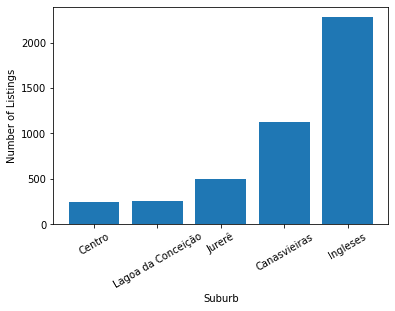

In [25]:
# Plotando gráfico para melhor visualização
plt.bar(df3_details.suburb, df3_details.airbnb_listing_id)
plt.xlabel('Suburb')
plt.xticks(rotation=30)
plt.ylabel('Number of Listings')

# 2. Ordene os bairros em ordem crescente de faturamento médio dos listings.

In [26]:
# Seleciona apenas os IDs ocupados
df2_price = df1_price.get(df1_price['occupied']==1)

In [27]:
# Combina os datasets
df_merged = pd.merge(df2_details, df2_price, how='inner')
df_merged.rename(columns={'price_string':'billing'}, inplace=True)

In [28]:
# Calcula a média de faturamento dos anúncios por bairro
df2_merged = df_merged.groupby('suburb', as_index=False).billing.mean().round(2)
df2_merged.sort_values(['billing'], inplace=True)
df2_merged

,suburb,billing
1,Centro,219.70
4,Lagoa da Conceição,243.83
0,Canasvieiras,294.30
2,Ingleses,350.27
3,Jurerê,414.28


Text(0, 0.5, 'Billing')

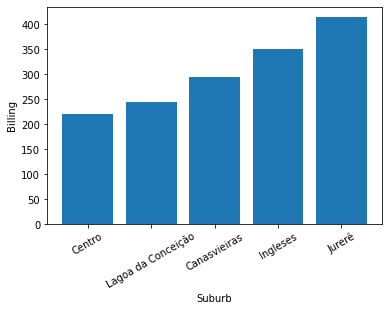

In [29]:
plt.bar(df2_merged.suburb, df2_merged.billing)
plt.xlabel('Suburb')
plt.xticks(rotation=30)
plt.ylabel('Billing')

# 3. Existem correlações entre as características de um anúncio e seu faturamento? Quais? Explique.

In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

X = encoder.fit_transform(df_merged.suburb.values.reshape(-1,1)).toarray()
X

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [31]:
suburb_encoded = pd.DataFrame(X, columns = ['Jurerê', 'Canasvieiras', 'Ingleses', 'Lagoa da Conceição', 'Centro'])

In [32]:
df_analysis = df_merged.join(suburb_encoded, lsuffix='_caller', rsuffix='_other')
df_analysis = df_analysis.drop(columns=['suburb', 'ad_name', 'booked_on', 'date', 'occupied'])

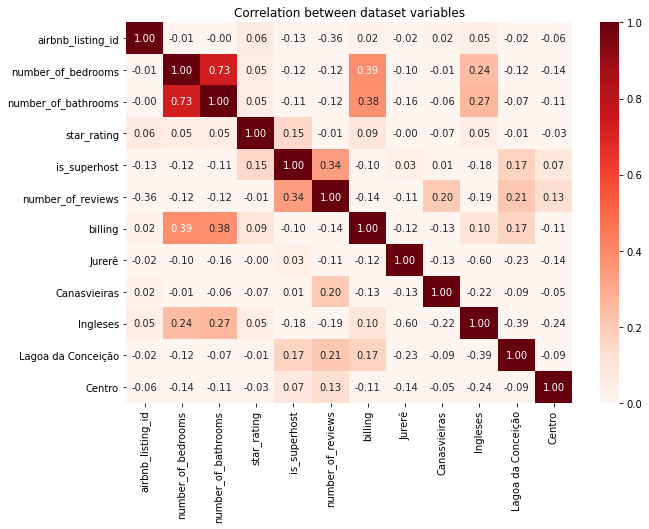

In [33]:
# Checando se há correlação positiva entre as features e o faturamento
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(df_analysis.corr(),
            annot = True,
            vmin=0,
            fmt = '.2f',
            cmap='Reds')
plt.title('Correlation between dataset variables')
plt.show()

### **CONCLUSÃO:** Através do gráfico de heatmap é possível observar que há sim uma correlação entre as features e o faturamento. Pode-se observar que: number_of_bedrooms', 'number_of_'bathrooms' tem uma forte correlação entre si e com o faturamento, e a feature 'star_rating', junto dos bairros: Ingleses e Lagoa da Conceição apesar de possuirem uma correlação mais fraca com o faturamento, ela também é considerável. 
### Pode-se absorver também dessa análise que ao alugar através de um anúncio no airbnb, as pessoas costumam procurar por um número de quartos e banheiros equivalente, o que pode estar relacionado com um maior aluguel de suites e geralmente localizados no bairro Ingleses já que esse possue forte correlação com a quantidade desses espaços

# 4. Qual a antecedência média das reservas? Esse número é maior ou menor para finais de semana?

In [47]:
# Transformando features de data em tipo datetime para poder manipulá-las
df3_price = df2_price.copy()

df3_price['booked_on'] = pd.to_datetime(df3_price['booked_on'])
df3_price['date'] = pd.to_datetime(df3_price['date'])

# Obtendo o dia da semana, começando na segunda-feira com o índice = 0
df3_price['days'] = df3_price['date'].dt.weekday

In [35]:
# Adiantamento de reservas em dias
df4_price = df3_price
df4_price['advance_booking'] = (df3_price['date'] - df3_price['booked_on']).dt.days
df4_price

,airbnb_listing_id,booked_on,date,price_string,occupied,days,advance_booking
12,40206270,2021-01-01,2021-01-01,380.0,1,4,0
13,40206270,2021-01-01,2021-01-02,380.0,1,5,1
52,40206270,2021-02-10,2021-02-10,195.0,1,2,0
53,40206270,2021-02-10,2021-02-11,350.0,1,3,1
54,40206270,2021-02-10,2021-02-12,350.0,1,4,2
...,...,...,...,...,...,...,...
354508,40199361,2020-09-16,2021-03-19,250.0,1,4,184
354514,40199361,2020-09-14,2021-03-25,250.0,1,3,192
354517,40199361,2020-09-14,2021-03-28,250.0,1,6,195
354518,40199361,2020-09-14,2021-03-29,250.0,1,0,196


In [36]:
df4_price['advance_booking'].sort_values()

12           0
85443        0
85444        0
85446        0
85450        0
          ... 
120661     369
120662     370
76559     7622
302698    7644
238097    7644
Name: advance_booking, Length: 140508, dtype: int64

Text(0.5, 1.0, 'Advance booking')

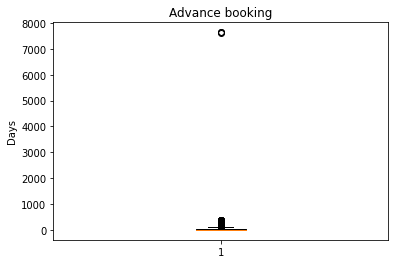

In [37]:
plt.boxplot(df4_price.advance_booking)
plt.ylabel('Days')
plt.title('Advance booking')

In [38]:
# Removendo outliers
df5_price = df4_price[df4_price.advance_booking < 36]
df5_price['advance_booking'].shape

(100692,)

Text(0.5, 1.0, 'Advance booking')

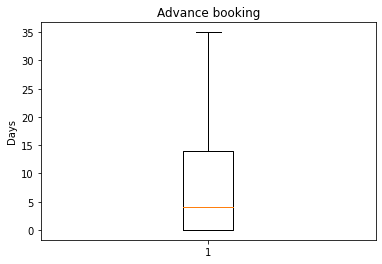

In [39]:
plt.boxplot(df5_price.advance_booking)
plt.ylabel('Days')
plt.title('Advance booking')

In [49]:
# Média de advance_booking
df5_price['advance_booking'].mean()

8.193997537043657

In [41]:
# Média de reservas realizadas por dia da semana
df6_price = df5_price.groupby('days', as_index=False).advance_booking.mean().round(2)
df6_price = df6_price.sort_values(['days'])
df6_price

,days,advance_booking
0,0,8.11
1,1,7.66
2,2,7.97
3,3,8.25
4,4,8.37
5,5,8.35
6,6,8.58


Text(0.5, 1.0, 'Advance booking')

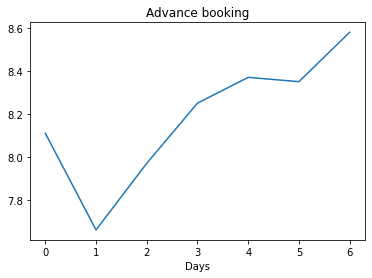

In [42]:
plt.plot(df6_price.days, df6_price.advance_booking)
plt.xlabel('Days')
plt.title('Advance booking')

## **CONCLUSÃO:** Desconsiderando os outliers, houve uma antecedência média de 8.19 dias nas reservas e esse número foi maior no final de semana

# Análise Bônus

## Para quando as propriedades foram alugadas com mais frequência

In [43]:
df7_price = df5_price.copy()
df7_price['months'] = df7_price['date'].dt.month_name()

In [44]:
# Checando os meses inclusos no dataset
df7_price['months'].unique()

array(['January', 'February', 'March', 'December', 'November'],
      dtype=object)

In [45]:
# Agrupando os dias e os meses por sua frequência
df_days = df7_price.groupby('days', as_index=False).days.count()
df_months = df7_price.groupby('months', as_index=False).months.count()

# Listas usadas para representar o eixo X nos gráficos
days = [
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
        'Sunday'
]

months = [
          'Jan',
          'Feb',
          'Mar',
          'Nov',
          'Dec'
]

Text(0.5, 1.0, 'Frequency of rented ads during the year')

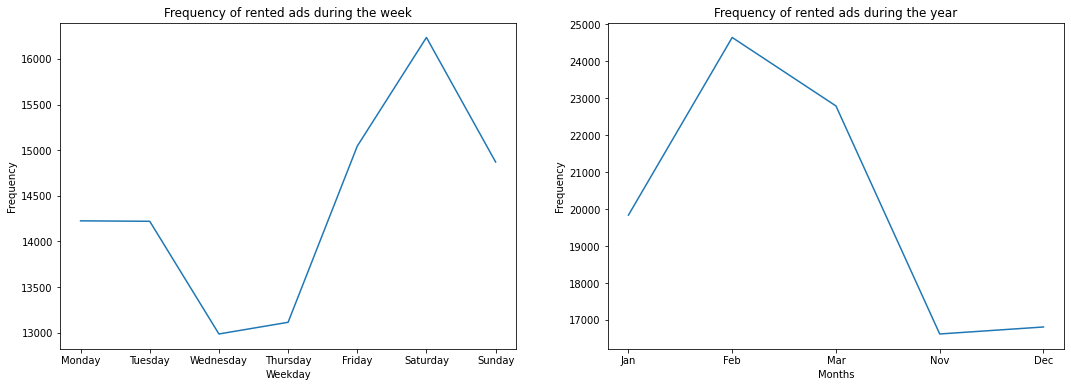

In [46]:
# Plotando gráficos para análise

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axes[0].plot(days, df_days)
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Frequency of rented ads during the week')

axes[1].plot(months, df_months)
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Frequency of rented ads during the year')

## **CONCLUSÃO:** Como pode ser visualizado nos gráficos a cima, os alugueis dos imoveis anunciados estão focados nos finais de semana e no primeiro trimestre do ano, correspondente ao verão